# SOC LEAF Permanent Crops Support
This notebook builds the SOC LEAF for *Coffee, irrigated* production will be developed for 2030. The process assumes that the land use is kept the same, and that weather and crop data do not change over time, generating LEAF for the input land use map using the default values previously mentioned on [SOC Documentation](../documentation/SOC_Documentation.md). 

## Data Download and Processing
As explained in SOC Documentation, several data layers need to be downloaded first. This examples uses all potential locations where coffee, irrigated could be grown according to [FAO GAEZ v2](https://www.fao.org/gaez/en/).

### Soil & Weather
Precipitation and air temperature data have been downloaded and processed. It be found under [data/](../data/). SoilGrids data have been downloaded and processed into UHTH zones in the needed format and is also available in the same folder. 

### Crop Data
Land use layer has been adapted from Morais, Teixeria & Domingos (2019) and can be found under [data/land_use](../data/land_use).

Commodity yield input data from FAO has already been summarized and can be found at [data/crops/fao_crop_yields_1423.csv](data/crops/fao_crop_yields_1423.csv) file. The needed SPAM data has been downloaded into [data/crops/spam2020V2r0_global_yield](data/crops/spam2020V2r0_global_yield) folder - Coffee and Maize data is uploaded, but other crops data layers are recommended to be placed under the same folder.

All other needed data to calculate potential crop evapotranspiration, including pre-calculated PET-location based layer, $\textstyle K_c$ values, stage durations, as well as other supporting data has been uploaded into [data/crops](../data/crops/) folder.

## Data Processing
Now that all data has been downloaded and prepared, the following modules are needed

In [ ]:
# Modules importing
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
import sbtn_leaf.RothC_Raster as rothC
import sbtn_leaf.cropcalcs as cropcalcs
import sbtn_leaf.map_plotting as mplot
import sbtn_leaf.PET as PET

# to handle file paths 
from sbtn_leaf.paths import data_path, examples_dir


import importlib

Could not determine dtype for column 1, falling back to string


In [6]:
importlib.reload(PET)

<module 'sbtn_leaf.PET' from 'C:\\Users\\loyola\\OneDrive - World Wildlife Fund, Inc\\Documents\\203. Python projects\\SBTN_Test\\src\\sbtn_leaf\\PET.py'>

Now the rest of the data can be prepared to calculate new LEAFs. The `cropcalcs.prepare_crop_data()` function automatizes the creation of yields maps, monthly plant cover, monthly PET, monthly irrigation, and monthly plant residue for a given land use commodity raster. All these inputs have their own function that can be directly run instead to reflect different primary data.

Before running the function, the following fields should be defined:

In [4]:
lu_filepath = data_path("land_use", "lu_Irrigated_Coffee.tif")
spam_all = data_path("crops","spam2020V2r0_global_yield","spam2020_V2r0_global_Y_COFF_A.tif")
spam_irr = data_path("crops","spam2020V2r0_global_yield","spam2020_V2r0_global_Y_COFF_I.tif")
spam_rain = data_path("crops","spam2020V2r0_global_yield","spam2020_V2r0_global_Y_COFF_R.tif")
input_data_output_folder = examples_dir() / "soc_ex_data"

Now running `cropcals.prepare_crop_data()` to ready all RothC inputs for Maize, rainfed. If this example has already been run, the function will skip generating already generated files. This should take a couple of minutes.

In [12]:
cropcalcs.prepare_crop_data(
    crop_name = "Coffee",
    crop_type= "permanent",
    crop_practice_string = "irr",
    lu_data_path = lu_filepath,
    spam_crop_raster = spam_irr,
    output_data_folder = input_data_output_folder,
    irr_yield_scaling = "irr",
    spam_all_fp = spam_all,
    spam_irr_fp = spam_irr,
    spam_rf_fp = spam_rain,
    all_new_files=True
)

Creating lu raster...
Creating PET raster...


Precomputing Kc curves for group: 100%|██████████| 6/6 [00:00<00:00, 65.63it/s]


Precomputing Kc curve for group: Tropics
Precomputing Kc curve for group: Subtropics summer rainfall
Precomputing Kc curve for group: Subtropics winter rainfall
Precomputing Kc curve for group: Oceanic temperate
Precomputing Kc curve for group: Sub-continental temperate and continental temperate
Precomputing Kc curve for group: Sub-continental boreal, continental boreal and polar/arctic


Applying Kc to thremal groups: 100%|██████████| 6/6 [00:00<00:00,  7.99it/s]


PET calculation completed for crop 'Coffee' succesfully.
Creating irrigation raster...
Irrigation raster saved to C:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\examples\soc_ex_data\Coffee_irr_monthly.tif
Creating Coffee, green helper shapefile...
Creating yield raster...
Average irrigated ratio: 3.56
Average rainfed ratio: 0.98
  → Applying irrigation scaling to all‐SPAM yields…
Yield raster written to C:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\examples\soc_ex_data\Coffee_irr_yield.tif
Creating plant cover raster...
Creating plant residue raster...
All data created for Coffee, irr!!!


### Inspecting outputs
Inspecting the yield data results.

In [13]:
coffee_irr_yields = examples_dir() / "soc_ex_data/Coffee_irr_yield.tif"

Raster has 199 unique values. Min: 0.00. Max: 7.13
Using quantiles
All positives route (quantiles)


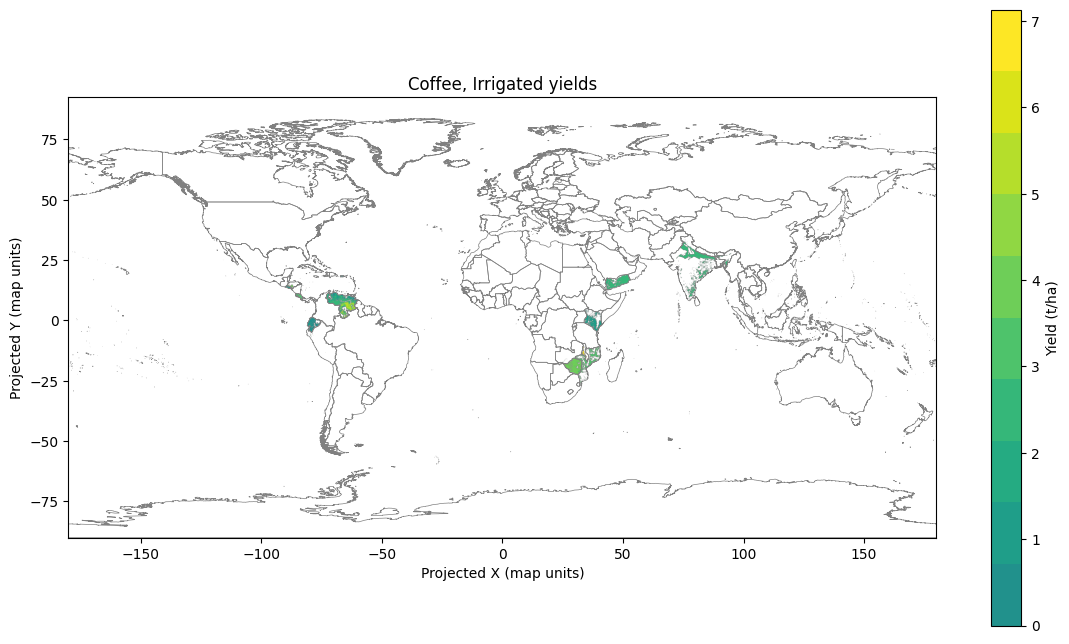

In [14]:
mplot.plot_raster_on_world_extremes_cutoff(
    coffee_irr_yields,
    title="Coffee, Irrigated yields",
    label_title="Yield (t/ha)",
    quantiles=10,
    perc_cutoff=0
)

Maize PET - Monthly

In [15]:
coffee_pet_monthly = examples_dir() / "soc_ex_data/Coffee_pet_monthly.tif"

Raster has 35,173 unique values. Min: 0.00. Max: 556.86
Using quantiles
All positives route (quantiles)


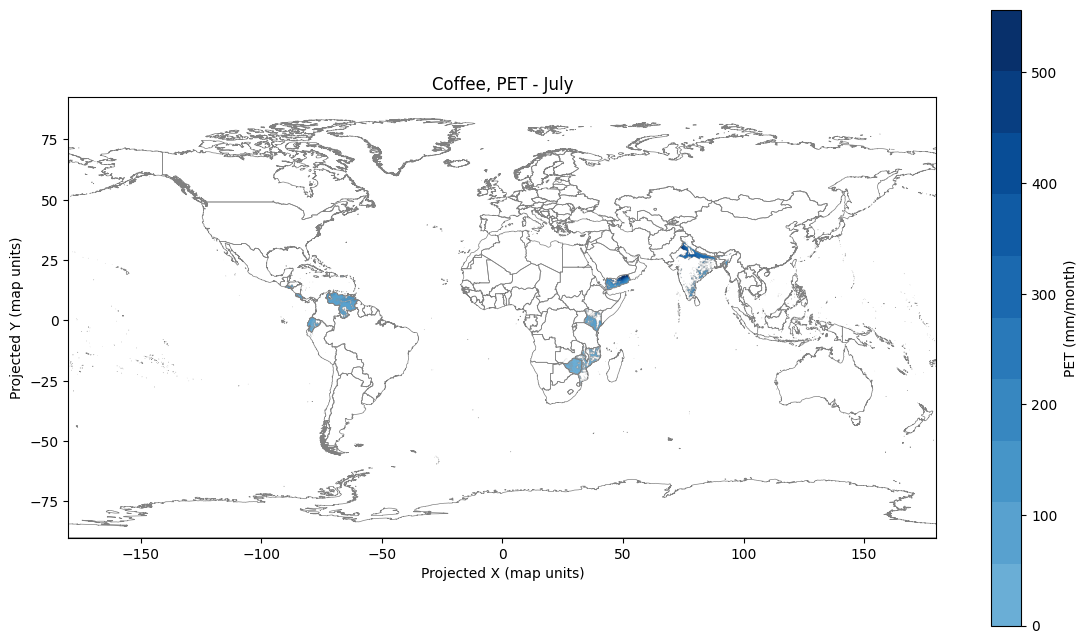

In [16]:
mplot.plot_raster_on_world_extremes_cutoff(
    coffee_pet_monthly,
    title="Coffee, PET - July",
    raster_band=7,
    label_title="PET (mm/month)",
    quantiles=10,
    cmap="Blues"
)

## RothC Modelling
With all data generated, the RothC model can be run. SoilGrids SOC data is from 2016, so in order to generate 2030 and 2050 maps aligned with SBTi's short and long-term targets, two LEAFs set will be generated: 34 and 54 years. Further, in this case, plant residues will be removed from the field, and traditional tillage applied.

Defining the needed additional inputs:

In [ ]:
evap =  examples_dir() / "soc_ex_data/Coffee_pet_monthly.tif"
pc =  examples_dir() / "soc_ex_data/Coffee_pc_monthly.tif"
leaf_output_folder =  examples_dir() / "soc_ex_output"

Now running the RothC model. Depending on the amount of years and land modelled, this could take from a few minutes to 1+ hours.

Running for 2030 scenario 

In [19]:
leaf_coffee_irr_2030 = rothC.run_RothC_crops(
    crop_name = "Coffee",
    commodity_type="permanent_crop", 
    practices_string_id= "irr",
    n_years = 34,
    save_folder = leaf_output_folder,
    data_description = "RothC model results after 34 years for Coffee, Irrigated",
    lu_fp = lu_filepath,
    evap_fp = evap,
    pc_fp = pc
)

Loading environmental data...
Loading crop data...
Running RothC...


RothC months:   0%|          | 0/408 [00:00<?, ?it/s]

#### Checking results
Now that results have been generated, they can be inspected.

In [20]:
soc_results = examples_dir() / "soc_ex_output/Coffee_irr_34y_SOC.tif"

Checking the properties of the raster...

In [21]:
mplot.inspect_raster(soc_results)

File: C:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\examples\soc_ex_output\Coffee_irr_34y_SOC.tif
Driver: GTiff
Width, Height: 4320, 2083
Number of Bands: 35
CRS: EPSG:4326
Bounds: BoundingBox(left=-179.99999999999997, bottom=-89.99999999999994, right=179.99999999999991, top=83.58333333333331)
Pixel Size: (0.0833333333333333, 0.0833333333333333)
No-data Value: nan

--- Raster Metadata ---
description: RothC model results after 34 years for Coffee, Irrigated
long_name: Soil Organic Carbon
model: RothC rasterized vectorized
units: t C/ha
AREA_OR_POINT: Area

--- Band Information ---

Band 1:
  Data Type: float32
  Min Value: 13.014917373657227
  Max Value: 145.71151733398438
  Mean Value: 41.886592864990234
  Standard Deviation: 16.42791175842285

Band 2:
  Data Type: float32
  Min Value: 12.361555099487305
  Max Value: 137.4407501220703
  Mean Value: 39.16956329345703
  Standard Deviation: 15.140496253967285

Band 3:
  Data Type: float32
  

Checking Global SOC evolution. This can be replicated or zoomed into a particular region or production unit.

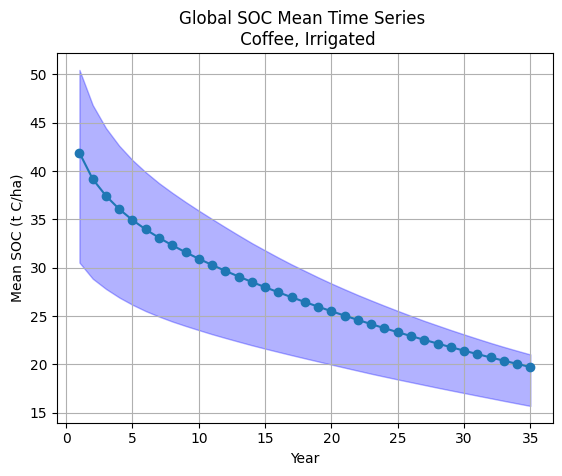

In [22]:
mplot.plot_multiband_raster_timesires(soc_results, "Global SOC Mean Time Series \n Coffee, Irrigated", show_iq=True)

It can be seen that, on average, SOC would be depleted under this operating conditions if kept over time.

Checking LEAF map for 2030

Raster has 36,087 unique values. Min: 10.38. Max: 55.34
Using quantiles
All positives route (quantiles)


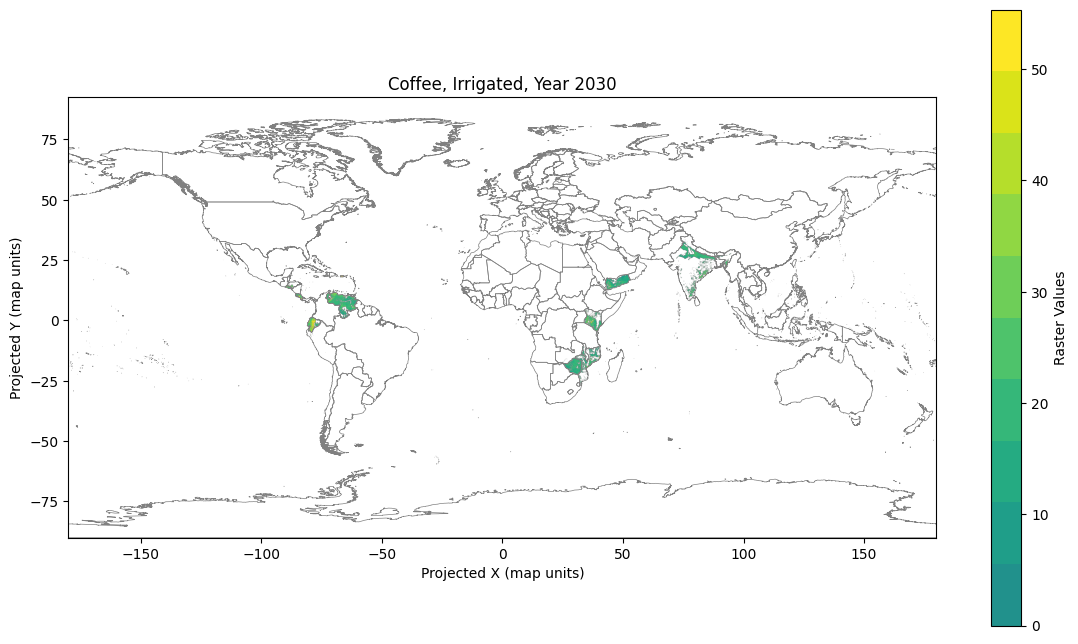

In [23]:
mplot.plot_raster_on_world_extremes_cutoff(soc_results, "Coffee, Irrigated, Year 2030", raster_band=34, perc_cutoff=1, quantiles=10)

Now checking how it changed between the baseline and 2030. This can be done with the function`rothC.calcuate_annual_perc_changes()`.

In [24]:
pct_change_2030 = rothC.calcuate_annual_perc_changes(soc_results)

Raster has 35,538 unique values. Min: -71.49. Max: 0.00
Using quantiles
All negatives route (quantiles)


(<Figure size 1400x800 with 2 Axes>,
 <Axes: title={'center': 'SOC Percentage change by year 2030 for \nCoffee Irrigated'}, xlabel='Projected X (map units)', ylabel='Projected Y (map units)'>)

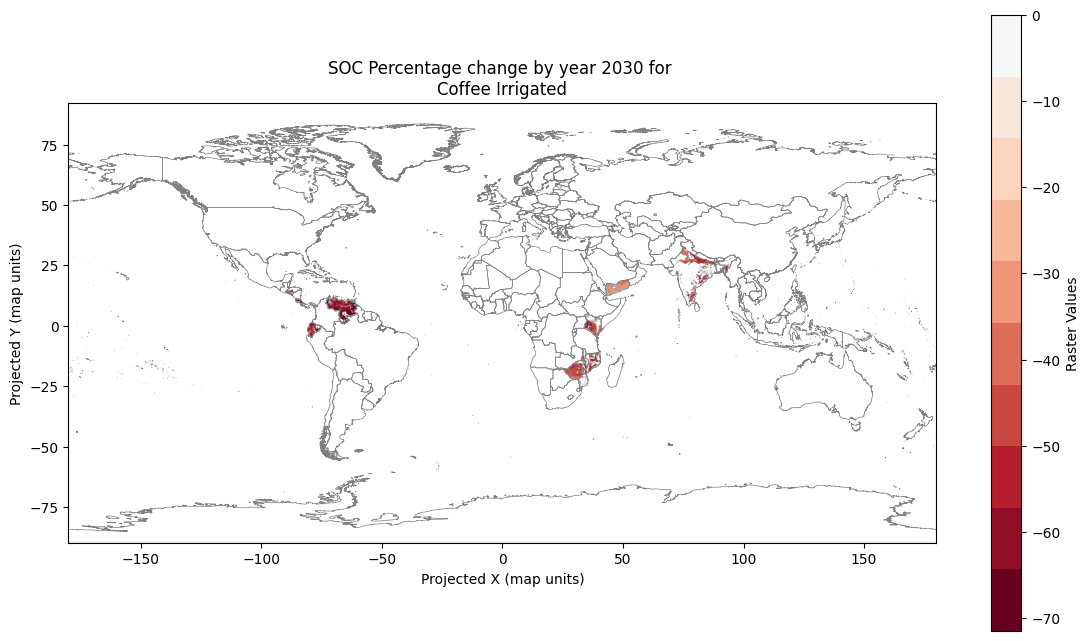

In [25]:
mplot.plot_da_on_world_extremes_cutoff(pct_change_2030, "SOC Percentage change by year 2030 for \nCoffee Irrigated", band=34, cmap="RdBu", quantiles=10) # type: ignore

Where it can be noted that there is no place where this operating conditions would increase SOC. Rather, SOC would decrease between 10% and 80% throughout the globe.